# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
#train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


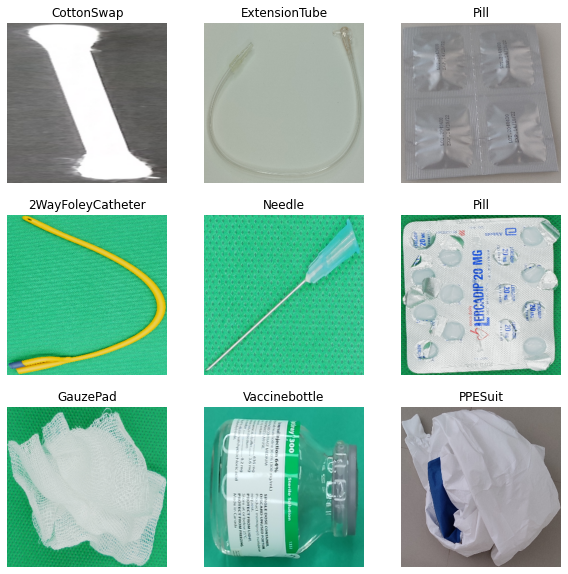

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-Oversampling-NoAug-VerySlowLR/'

In [20]:
EPOCHS = 2000
save_model_interval = 20
checkpoint_filepath = path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
192/192 [==============================] - 239s 697ms/step - loss: 0.4074 - accuracy: 0.8824 - val_loss: 1.6500 - val_accuracy: 0.7190
Epoch 2/2000
192/192 [==============================] - 108s 563ms/step - loss: 0.1096 - accuracy: 0.9689 - val_loss: 0.8053 - val_accuracy: 0.8184
Epoch 3/2000
192/192 [==============================] - 108s 561ms/step - loss: 0.0917 - accuracy: 0.9743 - val_loss: 2.1623 - val_accuracy: 0.5776
Epoch 4/2000
192/192 [==============================] - 108s 562ms/step - loss: 0.0636 - accuracy: 0.9809 - val_loss: 0.1043 - val_accuracy: 0.9726
Epoch 5/2000
192/192 [==============================] - 108s 561ms/step - loss: 0.0386 - accuracy: 0.9896 - val_loss: 0.4610 - val_accuracy: 0.8752
Epoch 6/2000
192/192 [==============================] - 108s 561ms/step - loss: 0.0593 - accuracy: 0.9835 - val_loss: 1.1006 - val_accuracy: 0.8171
Epoch 7/2000
192/192 [==============================] - 108s 561ms/step - loss: 0.0489 - accuracy: 0.9869 - val_

Text(0.5, 1.0, 'Training and Validation Accuracy')

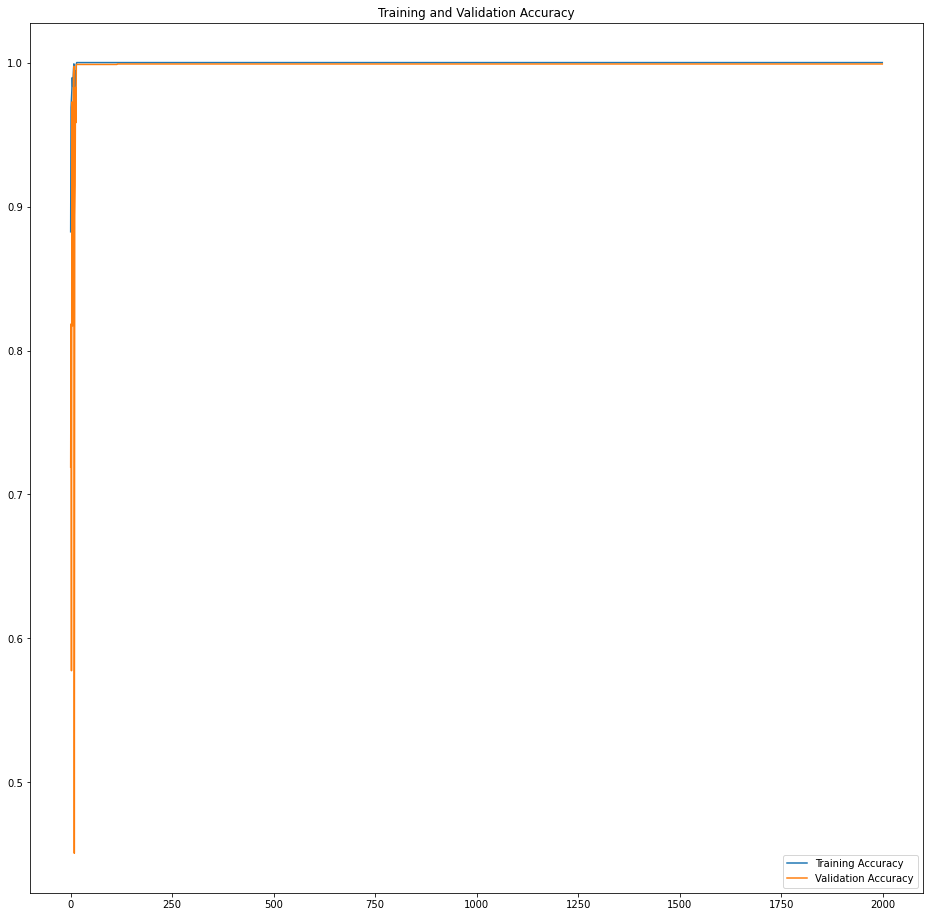

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


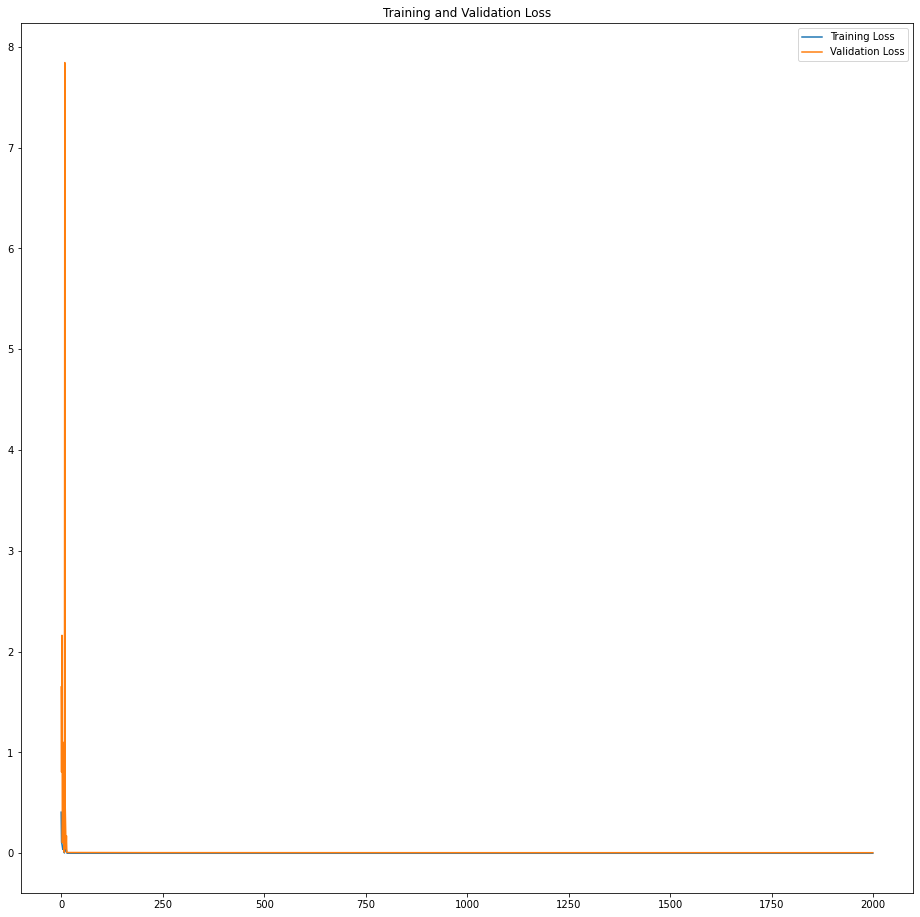

In [22]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 342ms/step - loss: 7.6681 - accuracy: 0.4470
test_indoor_ds_results:test loss, test acc: [7.6681365966796875, 0.4470457136631012]


In [24]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 438ms/step - loss: 3.7190 - accuracy: 0.5818
test_outdoor_ds_results:test loss, test acc: [3.7189972400665283, 0.5818471312522888]


In [25]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 200ms/step - loss: 1.4126 - accuracy: 0.7924
test_belt_ds_results:test loss, test acc: [1.4126235246658325, 0.7923843860626221]


In [26]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0020-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0040-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0060-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0080-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0100-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0120-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0140-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheck

# Testing in testset

In [27]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 133ms/step - loss: 1.2151 - accuracy: 0.7611
Epoch020 
 test_indoor_acc=0.4342252016067505 
 test_outdoor_acc=0.5493630766868591 
 test_belt_acc=0.7611060738563538
35/35 [==============================] - 5s 134ms/step - loss: 1.2178 - accuracy: 0.7688
Epoch040 
 test_indoor_acc=0.43478259444236755 
 test_outdoor_acc=0.5598726272583008 
 test_belt_acc=0.768812358379364
35/35 [==============================] - 5s 131ms/step - loss: 1.2231 - accuracy: 0.7720
Epoch060 
 test_indoor_acc=0.43756967782974243 
 test_outdoor_acc=0.562738835811615 
 test_belt_acc=0.7719854712486267
35/35 [==============================] - 5s 133ms/step - loss: 1.2467 - accuracy: 0.7738
Epoch080 
 test_indoor_acc=0.43756967782974243 
 test_outdoor_acc=0.5684713125228882 
 test_belt_acc=0.7737987041473389
35/35 [==============================] - 5s 133ms/step - loss: 1.2827 - accuracy: 0.7811
Epoch100 
 test_indoor_acc=0.4381271004676819 
 test_outdoor_acc=0.57707005739

range(20, 2020, 20)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

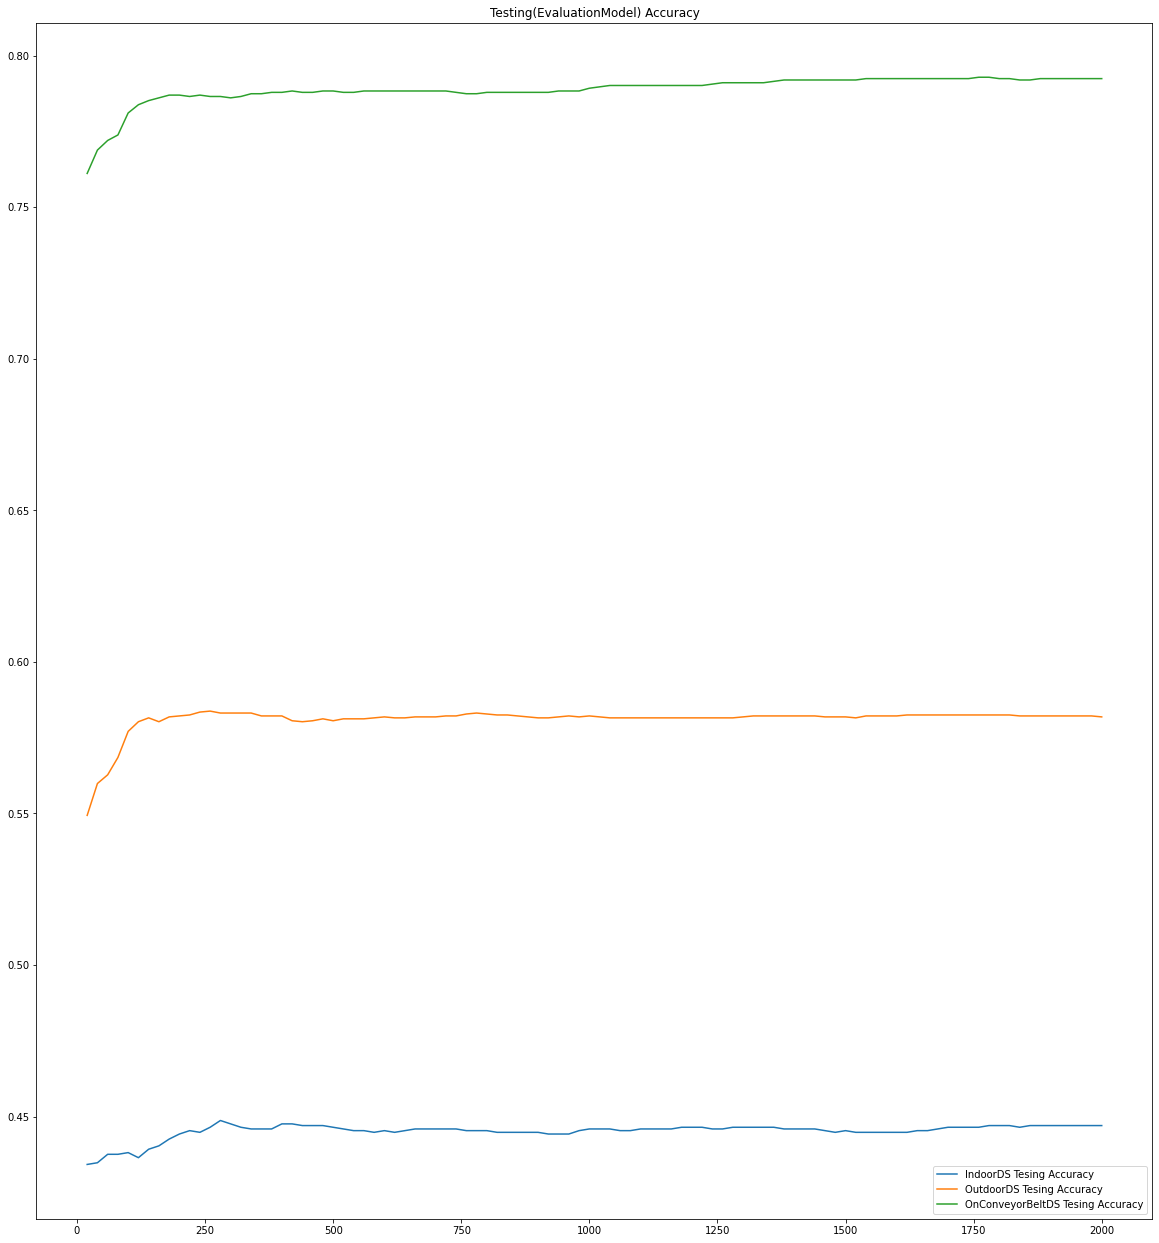

In [28]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

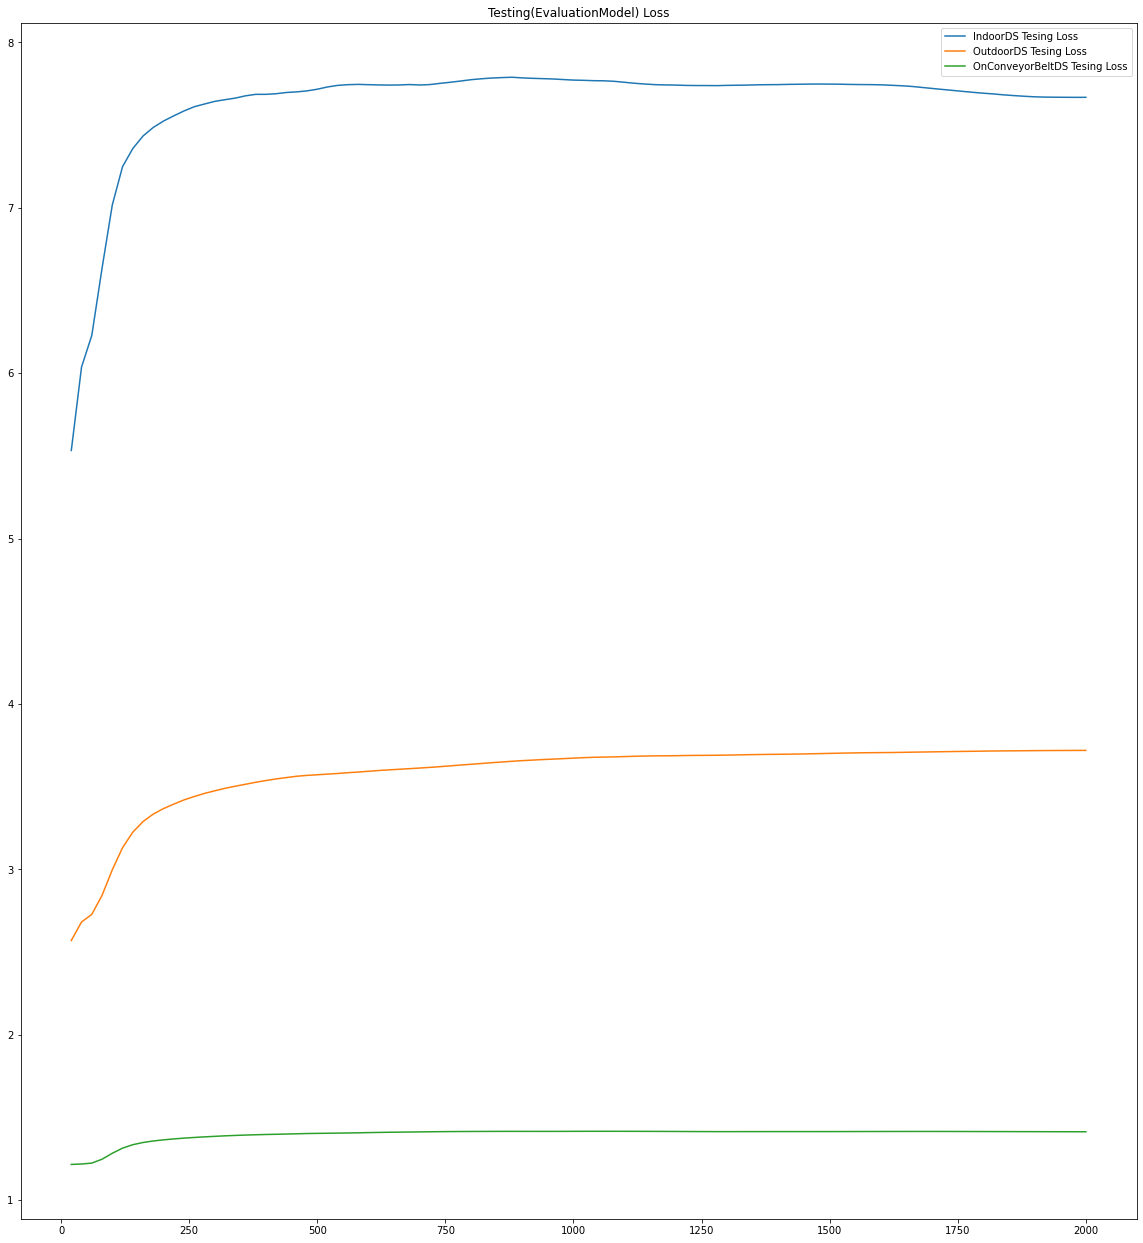

In [29]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [30]:
test_indoor_acc

[0.4342252016067505,
 0.43478259444236755,
 0.43756967782974243,
 0.43756967782974243,
 0.4381271004676819,
 0.4364548623561859,
 0.4392419159412384,
 0.4403567314147949,
 0.44258639216423035,
 0.4442586302757263,
 0.4453734755516052,
 0.44481605291366577,
 0.44648829102516174,
 0.44871795177459717,
 0.44760313630104065,
 0.44648829102516174,
 0.4459308683872223,
 0.4459308683872223,
 0.4459308683872223,
 0.44760313630104065,
 0.44760313630104065,
 0.4470457136631012,
 0.4470457136631012,
 0.4470457136631012,
 0.44648829102516174,
 0.4459308683872223,
 0.4453734755516052,
 0.4453734755516052,
 0.44481605291366577,
 0.4453734755516052,
 0.44481605291366577,
 0.4453734755516052,
 0.4459308683872223,
 0.4459308683872223,
 0.4459308683872223,
 0.4459308683872223,
 0.4459308683872223,
 0.4453734755516052,
 0.4453734755516052,
 0.4453734755516052,
 0.44481605291366577,
 0.44481605291366577,
 0.44481605291366577,
 0.44481605291366577,
 0.44481605291366577,
 0.4442586302757263,
 0.444258630275

In [31]:
test_outdoor_acc

[0.5493630766868591,
 0.5598726272583008,
 0.562738835811615,
 0.5684713125228882,
 0.5770700573921204,
 0.5802547931671143,
 0.5815286636352539,
 0.5802547931671143,
 0.5818471312522888,
 0.5821655988693237,
 0.5824840664863586,
 0.5834394693374634,
 0.5837579369544983,
 0.5831210017204285,
 0.5831210017204285,
 0.5831210017204285,
 0.5831210017204285,
 0.5821655988693237,
 0.5821655988693237,
 0.5821655988693237,
 0.5805732607841492,
 0.5802547931671143,
 0.5805732607841492,
 0.581210196018219,
 0.5805732607841492,
 0.581210196018219,
 0.581210196018219,
 0.581210196018219,
 0.5815286636352539,
 0.5818471312522888,
 0.5815286636352539,
 0.5815286636352539,
 0.5818471312522888,
 0.5818471312522888,
 0.5818471312522888,
 0.5821655988693237,
 0.5821655988693237,
 0.5828025341033936,
 0.5831210017204285,
 0.5828025341033936,
 0.5824840664863586,
 0.5824840664863586,
 0.5821655988693237,
 0.5818471312522888,
 0.5815286636352539,
 0.5815286636352539,
 0.5818471312522888,
 0.582165598869323

In [32]:
test_belt_acc

[0.7611060738563538,
 0.768812358379364,
 0.7719854712486267,
 0.7737987041473389,
 0.7810516953468323,
 0.7837715148925781,
 0.7851314544677734,
 0.7860381007194519,
 0.7869446873664856,
 0.7869446873664856,
 0.7864913940429688,
 0.7869446873664856,
 0.7864913940429688,
 0.7864913940429688,
 0.7860381007194519,
 0.7864913940429688,
 0.7873979806900024,
 0.7873979806900024,
 0.7878513336181641,
 0.7878513336181641,
 0.7883046269416809,
 0.7878513336181641,
 0.7878513336181641,
 0.7883046269416809,
 0.7883046269416809,
 0.7878513336181641,
 0.7878513336181641,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7883046269416809,
 0.7878513336181641,
 0.7873979806900024,
 0.7873979806900024,
 0.7878513336181641,
 0.7878513336181641,
 0.7878513336181641,
 0.7878513336181641,
 0.7878513336181641,
 0.7878513336181641,
 0.7878513336181641,
 0.7883046269416809,
 0.78830462694

In [33]:
test_indoor_loss

[5.532717227935791,
 6.037275314331055,
 6.228358268737793,
 6.634279727935791,
 7.016940593719482,
 7.248683929443359,
 7.3582682609558105,
 7.4342217445373535,
 7.486065864562988,
 7.524722576141357,
 7.5560431480407715,
 7.585659980773926,
 7.611232280731201,
 7.6276421546936035,
 7.643649578094482,
 7.653804779052734,
 7.663279056549072,
 7.677219867706299,
 7.686122417449951,
 7.686103343963623,
 7.68997049331665,
 7.697347164154053,
 7.701056957244873,
 7.7069807052612305,
 7.7170186042785645,
 7.730717658996582,
 7.740270614624023,
 7.744565963745117,
 7.746270179748535,
 7.744566917419434,
 7.742926120758057,
 7.7420196533203125,
 7.742730140686035,
 7.745392799377441,
 7.742649078369141,
 7.745223522186279,
 7.752622604370117,
 7.7592573165893555,
 7.7665934562683105,
 7.7746124267578125,
 7.7801642417907715,
 7.784656524658203,
 7.787363529205322,
 7.7895188331604,
 7.785581588745117,
 7.782933235168457,
 7.781104564666748,
 7.779022693634033,
 7.775599002838135,
 7.772262096

In [34]:
test_outdoor_loss

[2.5695574283599854,
 2.6813206672668457,
 2.7270874977111816,
 2.842257261276245,
 2.996701717376709,
 3.1305201053619385,
 3.2242374420166016,
 3.2884905338287354,
 3.333854913711548,
 3.367042303085327,
 3.3941662311553955,
 3.4195218086242676,
 3.439997673034668,
 3.4588258266448975,
 3.474600315093994,
 3.4896438121795654,
 3.502169609069824,
 3.514073133468628,
 3.526172161102295,
 3.5368704795837402,
 3.5464131832122803,
 3.5546231269836426,
 3.5626018047332764,
 3.5677151679992676,
 3.57143235206604,
 3.5753774642944336,
 3.5793917179107666,
 3.584044933319092,
 3.5879065990448,
 3.592515230178833,
 3.5973000526428223,
 3.601161003112793,
 3.6047301292419434,
 3.6084485054016113,
 3.612217903137207,
 3.616121292114258,
 3.6205673217773438,
 3.625488519668579,
 3.630486488342285,
 3.6348421573638916,
 3.639630079269409,
 3.644347667694092,
 3.6485893726348877,
 3.653109550476074,
 3.656954765319824,
 3.6601574420928955,
 3.663483142852783,
 3.6661248207092285,
 3.669027328491211

In [35]:
test_belt_loss

[1.215094804763794,
 1.2177670001983643,
 1.2231450080871582,
 1.246695637702942,
 1.2827024459838867,
 1.3137648105621338,
 1.3344330787658691,
 1.347786784172058,
 1.3570117950439453,
 1.3637628555297852,
 1.3694581985473633,
 1.3742173910140991,
 1.3782236576080322,
 1.3818418979644775,
 1.3850148916244507,
 1.388060212135315,
 1.3905494213104248,
 1.3927505016326904,
 1.3945962190628052,
 1.3962904214859009,
 1.397469401359558,
 1.398990273475647,
 1.4005153179168701,
 1.401980996131897,
 1.4029737710952759,
 1.4036585092544556,
 1.4045360088348389,
 1.40542471408844,
 1.4063886404037476,
 1.4075695276260376,
 1.4087402820587158,
 1.4097013473510742,
 1.4103784561157227,
 1.4110554456710815,
 1.4118666648864746,
 1.412581205368042,
 1.4133243560791016,
 1.413902997970581,
 1.4141590595245361,
 1.4144655466079712,
 1.4146876335144043,
 1.4149072170257568,
 1.4151002168655396,
 1.415138840675354,
 1.415034532546997,
 1.4149770736694336,
 1.4149361848831177,
 1.414967656135559,
 1.415

## Load Last Epoch and test in each class

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch1500-val_acc1.00.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4373
FP=2767
acc=0.6124649859943978
all check = 7140


In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 73.27586206896551%
2WayConnectorforFoley acc = 74.14965986394559%
2WayFoleyCatheter acc = 50.74626865671642%
3WayConnectorforFoley acc = 74.35897435897436%
3Waystopcock acc = 87.38738738738738%
AlcoholBottle acc = 83.75%
AlcoholPad acc = 41.269841269841265%
BootCover acc = 61.44578313253012%
CottonBall acc = 79.64071856287424%
CottonSwap acc = 52.44755244755245%
Dilator acc = 64.1025641025641%
DisposableInfusionSet acc = 46.017699115044245%
ExtensionTube acc = 18.69918699186992%
FaceShield acc = 48.76543209876543%
FrontLoadSyringe acc = 15.04424778761062%
GauzePad acc = 32.38636363636363%
Glove acc = 47.023809523809526%
GuideWire acc = 23.214285714285715%
LiquidBottle acc = 55.72519083969466%
Mask acc = 88.83116883116882%
NGTube acc = 30.967741935483872%
NasalCannula acc = 43.36283185840708%
Needle acc = 65.35714285714286%
OxygenMask acc = 51.127819548872175%
PPESuit acc = 89.51612903225806%
PharmaceuticalProduct acc = 61.915887850467286%
Pill acc = 92.57703

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 85,   0,   5, ...,   0,   0,   0],
       [  2, 109,   3, ...,   0,   1,   0],
       [  0,   0,  68, ...,   0,   0,   4],
       ...,
       [  0,   0,   0, ...,  30,   5,   0],
       [  0,   0,   3, ...,   0, 160,   0],
       [  0,   0,  13, ...,   1,   7,  43]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[73.27586207,  0.        ,  4.31034483, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36054422, 74.14965986,  2.04081633, ...,  0.        ,
         0.68027211,  0.        ],
       [ 0.        ,  0.        , 50.74626866, ...,  0.        ,
         0.        ,  2.98507463],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 25.        ,
         4.16666667,  0.        ],
       [ 0.        ,  0.        ,  1.4084507 , ...,  0.        ,
        75.11737089,  0.        ],
       [ 0.        ,  0.        , 11.40350877, ...,  0.87719298,
         6.14035088, 37.71929825]])

<AxesSubplot:>

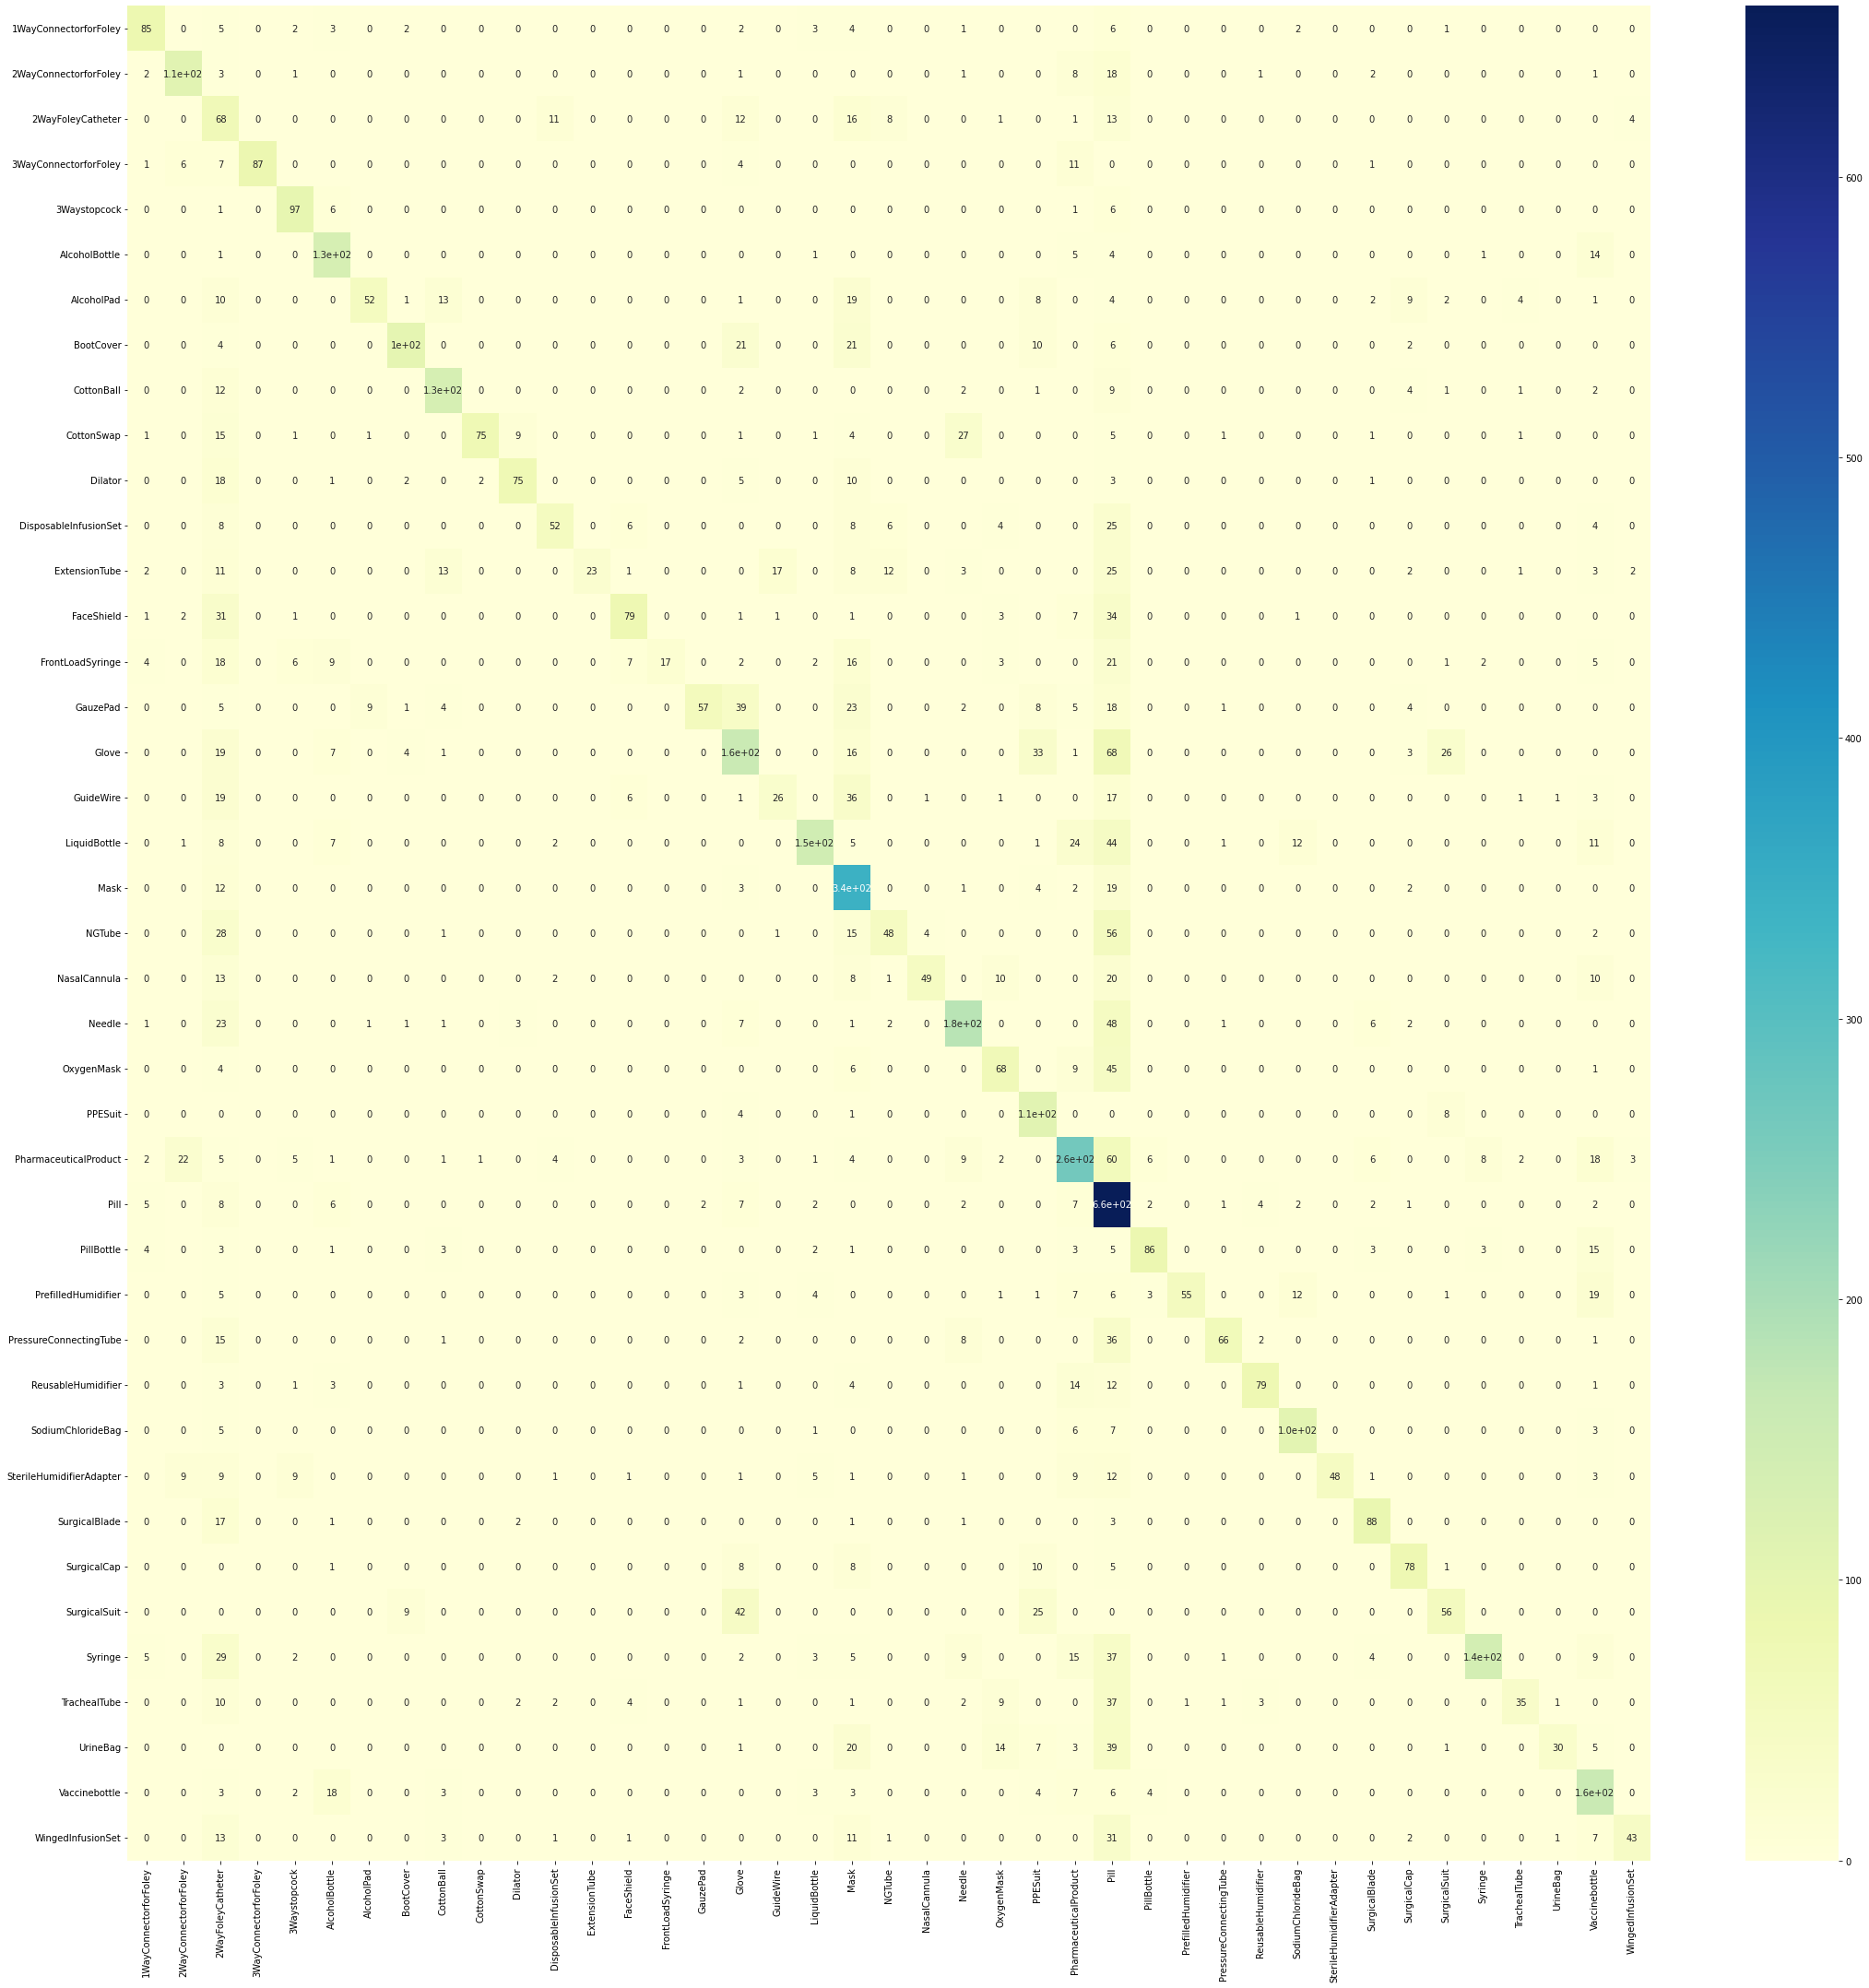

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

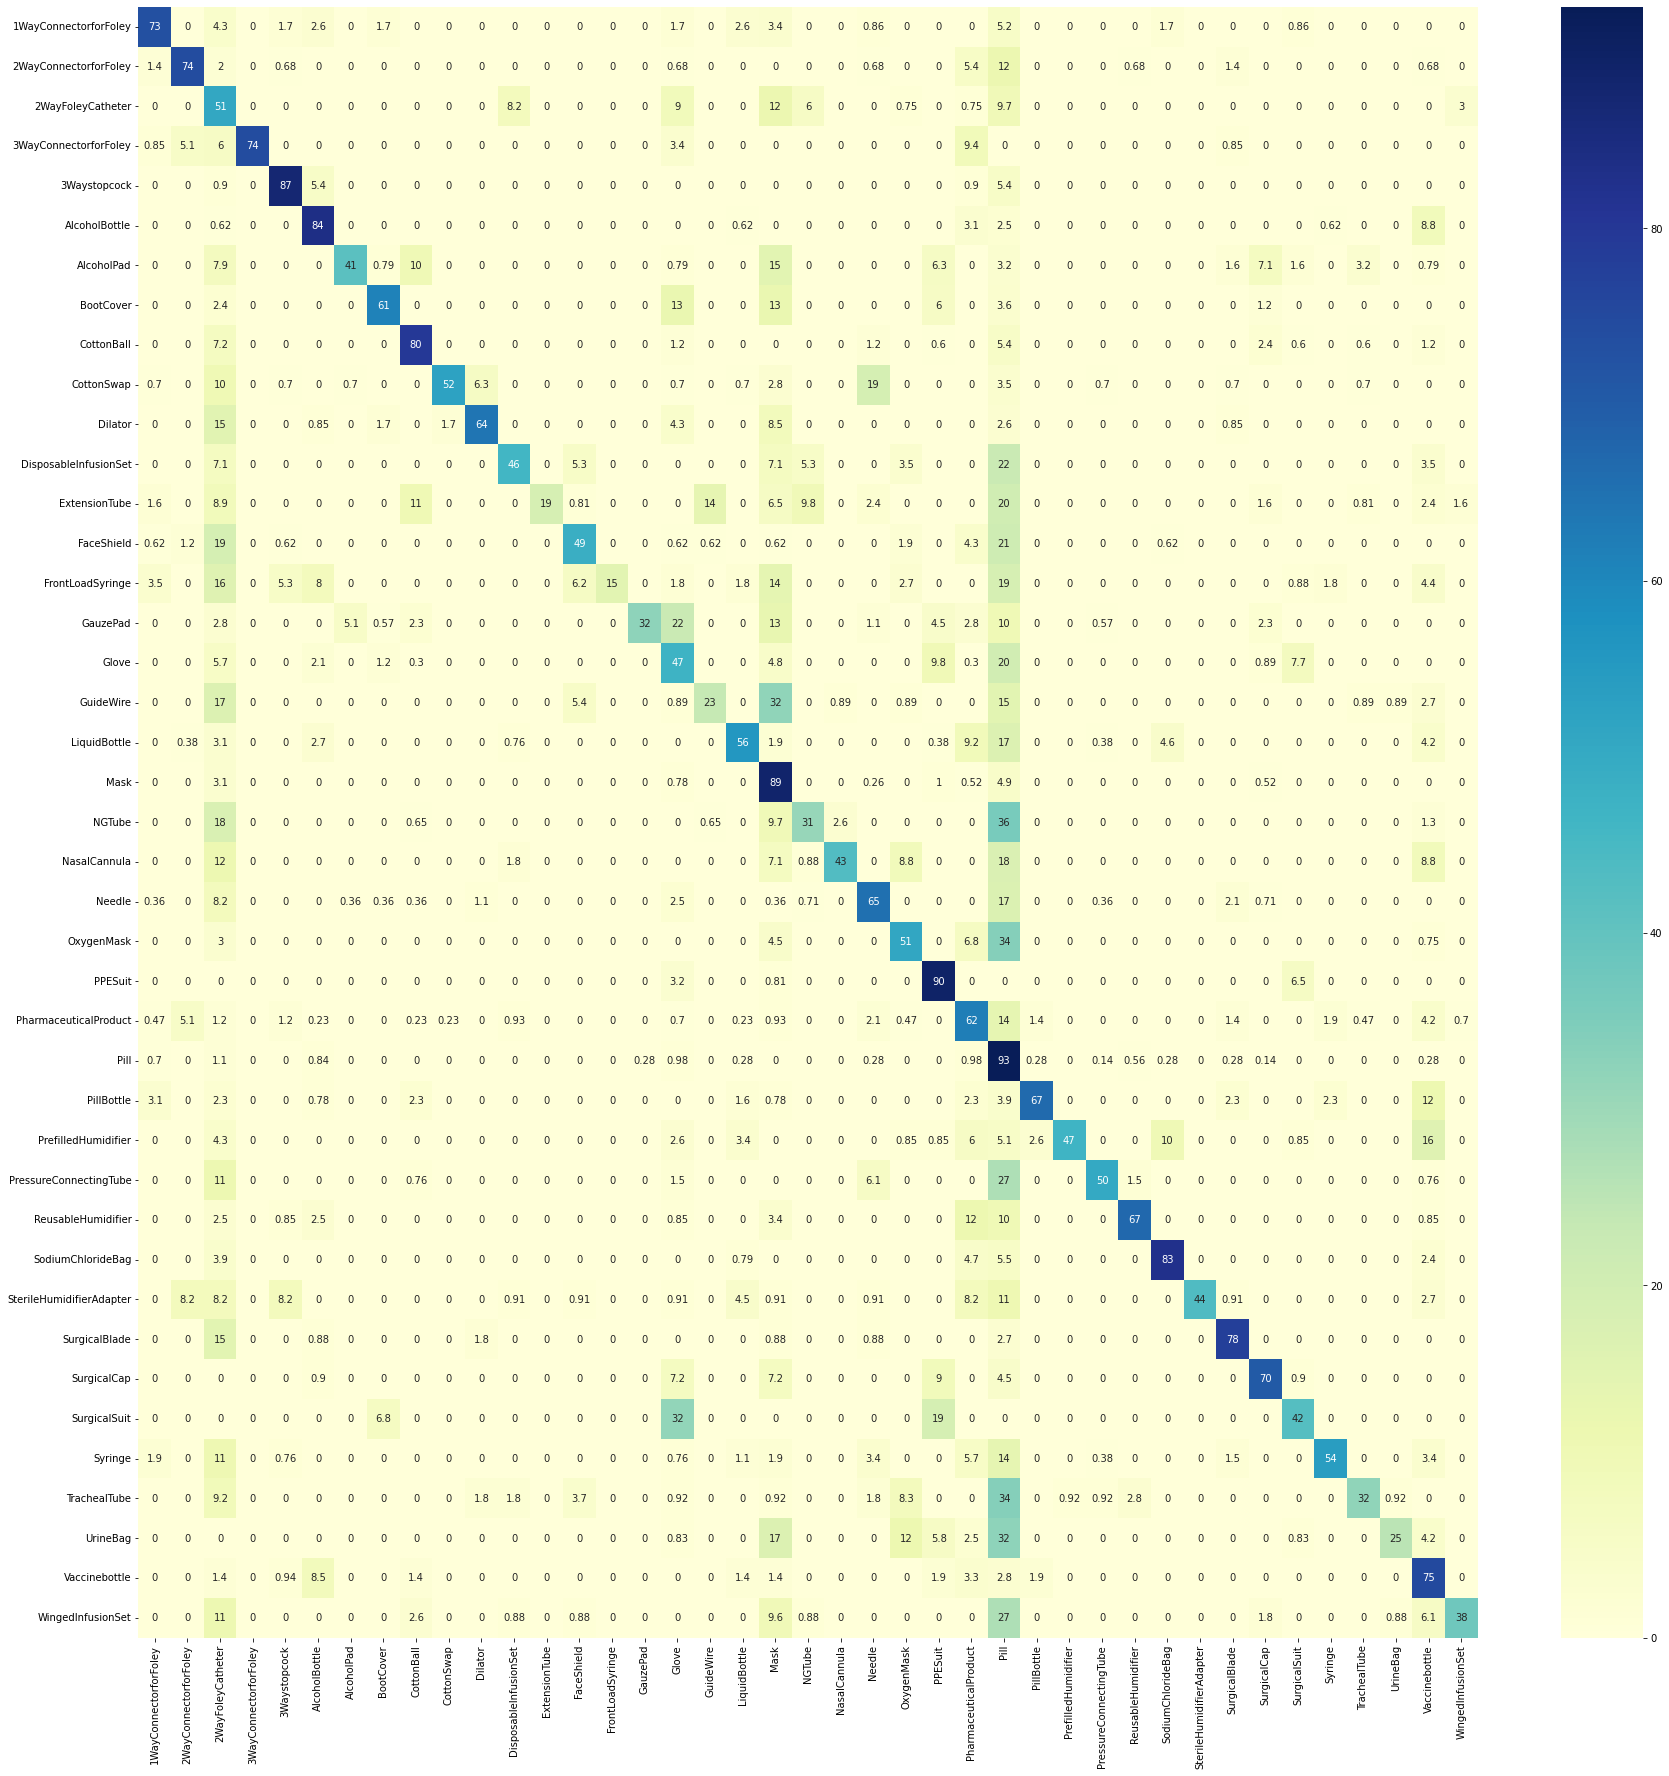

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")